In [63]:
%matplotlib notebook
import numpy as np
import pandas as pd
from IPython.display import clear_output # Paquete para 
import matplotlib.pyplot as plt # Paquete para grafica de datos
import serial # libreria para transmisión Serial
import csv # Libreria para escribir csv
from scipy import fft,stats # Paquete para la transformada de Fourier, y valores atipicos
from scipy.optimize import curve_fit # Paquete para ajuste de curvas a los datos
from scipy.signal import savgol_filter,find_peaks,peak_widths # Paquetes de suavizado de curva, encontrar picos y su ancho

## 1. Calibración del sensor HC-SR04

R2 es 0.9994
[0.96486813 0.24027473] [0.00694689 0.30676623]


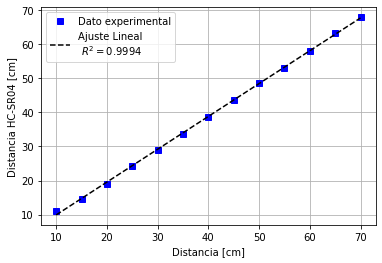

In [62]:
%matplotlib inline

def f(x,a,b):
    '''
    Funcion para ajuste lineal
    '''
    return a*x+b

def get_R2(fopt,x,y):
    '''
    Funcion para el calculo del coeficiente de correlacion
    '''
    R2 = 1-((np.sum((fopt(x)-y)**2))/(np.var(y)*y.shape[0]))
    print('R2 es {:.4f}'.format(R2))
    return R2

dataCal = pd.read_csv('calibracion.csv',header=None).to_numpy('float') # Lee el archivo de calibracion del sensor
vals = np.arange(10,75,5) #Valores de distancia medidos con regla: 10, 15,...,70
vals_sensor = np.zeros((vals.shape[0],2))
vals_sensor[0,0] = np.mean(dataCal[0:20]) # Calcula el promedio de las 20 mediciones de cada distancia.
vals_sensor[0,1] = np.std(dataCal[0:20]) # Calcula la desviación estandar de las 20 mediciones de cada distancia.
for i in range(vals.shape[0]):
    vals_sensor[i,0] = np.mean(dataCal[i*20:(i+1)*20]) # Calcula el promedio de las 20 mediciones de cada distancia.
    vals_sensor[i,1] = np.std(dataCal[i*20:(i+1)*20]) # Calcula la desviación estandar de las 20 mediciones de cada distancia.
plt.plot(vals,vals_sensor[:,0],'bs')
popt, pcov = curve_fit(f,vals,vals_sensor[:,0])
def getDistance(x):
    return popt[0]*x+popt[1]
plt.plot(vals,getDistance(vals),'k--',label='Ajuste Lineal\n $R^2={:.4f}$'.format(get_R2(getDistance,vals,vals_sensor[:,0])))
ax = plt.gca()
ax.set_xlabel('Distancia [cm]')
ax.set_ylabel('Distancia HC-SR04 [cm]')
plt.grid()
plt.legend()
name_fig = 'calibracion'
plt.savefig(name_fig,dpi=200,bbox_inches='tight')

## 2. Cálculo del momento de Inercia

In [3]:
r_h = 61.4/2 #hollow cylinder
r_d = r_h #disk
A_tot = 2*np.pi*(r_h)*61+np.pi*(r_h)**2
m_tot = 10.8
rho = m_tot/A_tot
m_h = 2*np.pi*(r_h)*rho
m_d =np.pi*r_h**2*rho+55*2
m_s, r_s, l_s = 19.1,7.30, 50.4 #screws
m_n, r_n1, r_n2 = 4.2,12.60-3.5,12.60 #nuts
m_b, s1, s2 = 1, 1, 1 #breadboard, side1, side2
dm = 0.1 #g
dr = 0.02 #mm
def MoI(r_a,r_b):
    dra = 5
    I_h = m_h*r_h**2
    d1 = I_h*(2*dr/r_h+dm/m_h)
    I_d = 0.5*m_d*r_d**2
    d2 = I_d*(2*dr/r_h+dm/m_d)
    I_s = 4*(m_s*r_h**2 + 1/4*m_s*r_s**2 + 1/12*m_s*l_s**2)
    d3 = 4*(m_s*r_h**2*(2*dr/r_h+dm/m_d)+(1/4*m_s*r_s**2)*(2*dr/r_s+dm/m_s)+
            (1/12*m_s*l_s**2)*(2*dr/l_s+dm/m_s))
    I_n = 4*(m_n*r_h**2+m_n/4*(r_n1**2+r_n2**2))
    d4 = 4*((m_n*r_h**2)*(2*dr/r_h+dm/m_n)+(m_n/4*(r_n1**2+r_n2**2))
            *(dm/m_n+2*dr*(r_n1+r_n2)/(r_n1**2+r_n2**2)))
    I_na = 2*(m_n*r_a**2+m_n/4*(r_n1**2+r_n2**2))
    d5 = 2*((m_n*r_a**2)*(dm/m_n+2*dra/r_a)+m_n/4*(r_n1**2+r_n2**2)*
            (dm/m_n+2*dr*(r_n1+r_n2)/(r_n1**2+r_n2**2)))
    I_nb = 2*(m_n*r_b**2+m_n/4*(r_n1**2+r_n2**2))
    d6 = 2*((m_n*r_b**2)*(dm/m_n+2*dra/r_b)+m_n/4*(r_n1**2+r_n2**2)*
            (dm/m_n+2*dr*(r_n1+r_n2)/(r_n1**2+r_n2**2)))
    ##
    I = I_h+I_d+I_s+I_n+I_na+I_nb
    dI = d1+d2+d3+d4+d5+d6
    return I/(1000)**3,dI/(1000)**3 # [I] = kg*m^2

In [4]:
def max2Frec(xf,yf,height=0.2): ##Funcion que encuentra los dos picos del movimiento
    peaks_index, properties = find_peaks(yf,height=height)
    widths = peak_widths(yf, peaks_index, rel_height=0.5)[0]*(xf[-1]/xf.shape[0])
    if peaks_index.shape[0] >= 2:
        results = np.zeros((2,2))
        argmax0 = np.argmax(properties['peak_heights'])
        index0 = peaks_index[argmax0]
        results[0,0], results[0,1] = xf[index0],widths[argmax0]
        argmax1 = np.argmax(np.delete(properties['peak_heights'],argmax0))
        index1 = peaks_index[argmax1]
        results[1,0], results[1,1] = xf[index1],widths[argmax1]
        return results
    else:
        results = np.array([xf[peaks_index[0]],widths[0]])
        return results

## 3. Lectura del puerto serial y graficación en vivo

<IPython.core.display.Javascript object>


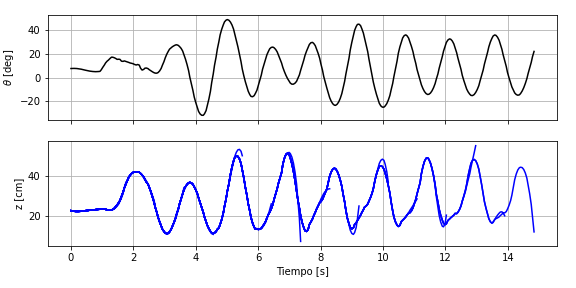

In [67]:
%matplotlib notebook

sensor = serial.Serial('COM5',9600) # Lee el puerto serial COM5
datos = pd.DataFrame() # Guarda los datos tomados en un cuadro de datos de Pandas

# Ajustes preliminares de la gráfica

fig, ax = plt.subplots(2,1,sharex=True,figsize=(8, 4))
ax[1].set_ylabel('z [cm]')
ax[1].set_xlabel('Tiempo [s]')
ax[0].grid()
ax[1].grid()
fig.subplots_adjust(hspace=0.05)
fig.tight_layout()
plt.ion()
fig.show()
fig.canvas.draw()

# Posicion de las cuatro tuercas para calculo del momento de inercia

ra = r_h + 30
rb = r_h + 30

i = 0 # Indice para nombre del archivo 

sfx = 'TEST'
name = 'datosTheta_'+sfx+str(i)+'.csv' #a,b,c,d,e,f,g,h
f = open(name,'w',newline='')
writer = csv.writer(f)

nn = 0
while True:
    try:
        signal = str(sensor.readline())[2:-5]
        signal = np.array(signal.split(' ')).astype(float)
        writer.writerow(signal)
        datos = datos.append(pd.Series(signal),ignore_index=True)
        nn = nn+1
        if nn%20 == 0: # Grafica cada 20 datos
            datos = datos[(np.abs(stats.zscore(datos[0]))<3)] # Elimina los datos atipicos bajo un criterio estadistico
            ax[0].clear()
            t = datos.iloc[:,0].to_numpy('float')
            theta = datos.iloc[:,1].to_numpy('float')
            z = datos.iloc[:,2].to_numpy('float')
            z = savgol_filter(z, 19, 3) # Suaviza los datos a través de regresion en una ventana de 19 datos
            ax[0].plot(t,theta,'rtn-')
            ax[0].set_ylabel('$\\theta$ [deg]')
            ax[1].plot(t,z,'b-')
            ax[0].grid()
            fig.canvas.draw()
    except KeyboardInterrupt:
        sensor.close()
        f.close()
        datos = datos.rename(columns={0:'Tiempo[s]',1:'Angulo[deg]',2:'Distancia[cm]'})
        break

In [68]:
sensor.close() #Correr esta celda si el puerto quedo abierto por alguna razon

In [69]:
# datos = pd.read_csv('datosa0.csv',header=None) # Archivo de lectura para analizar los datos
datos = datos.rename(columns={0:'Tiempo[s]',1:'Angulo[deg]',2:'Distancia[cm]'})
# datos = datos.rename(columns={0:'Tiempo[s]',1:'Distancia[cm]'})
print(datos)

     Tiempo[s]  Angulo[deg]  Distancia[cm]
0         0.00         7.75          22.81
1         0.05         7.84          22.72
2         0.10         7.85          22.19
3         0.14         7.81          22.57
4         0.19         7.74          22.11
..         ...          ...            ...
327      15.25        27.64          20.03
328      15.30        23.85          20.65
329      15.35        19.65          21.81
330      15.39        15.21          21.76
331      15.44        10.74          22.59

[332 rows x 3 columns]


## 4. Análisis de datos

Antes del Filtro:
Tiempo[s]        15.44
Angulo[deg]      49.12
Distancia[cm]    51.88
dtype: float64
(332, 3)
Después del Filtro:
Tiempo[s]        15.44
Angulo[deg]      49.12
Distancia[cm]    51.88
dtype: float64
(332, 3)


<Figure size 432x288 with 0 Axes>

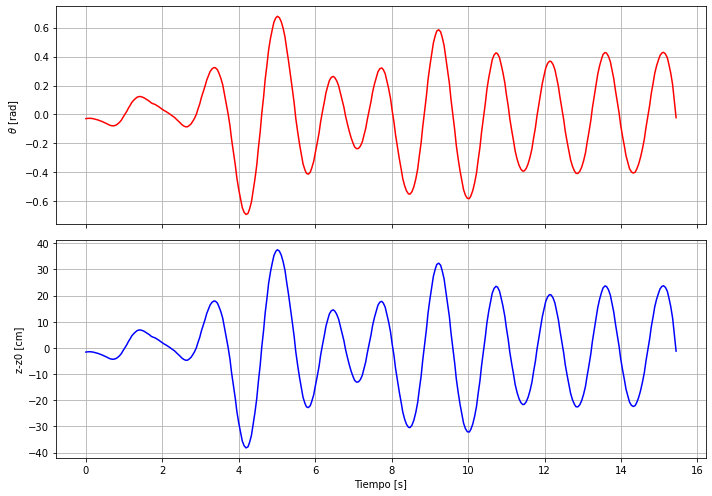

In [71]:
%matplotlib inline

# Limpia los datos, en particular aquellos que se encuentren muy lejos del resto

print('Antes del Filtro:')
print(datos.max())
print(datos.shape)
print('Después del Filtro:')
datos = datos[(np.abs(stats.zscore(datos['Distancia[cm]']))<3)]
print(datos.max())
print(datos.shape)

# Guarda los datos en cada vairable: tiempo t, theta, z

t = datos.iloc[:,0].to_numpy('float')
theta = datos.iloc[:,1].to_numpy('float')*np.pi/180
z = getDistance(datos.iloc[:,1].to_numpy('float'))

# Suaviza los datos y ajusta el cero en z

theta = savgol_filter(theta, 21, 3)
theta = theta-np.mean(theta)
z = savgol_filter(z, 21, 3)
z = z-np.mean(z)

#Calcula el momento de incercia

I,dI = MoI(ra,rb)
plt.suptitle('Transformadas de Fourier, $I$ = {:.2E} kg m$^2$'.format(I),fontsize=10)

#Grafica los datos

fig, ax = plt.subplots(2,1,sharex=True,figsize=(10, 7))
ax[0].plot(t,theta,'r-')
ax[0].set_ylabel('$\\theta$ [rad]')
ax[1].plot(t,z,'b-')
ax[1].set_ylabel('z-z0 [cm]')
ax[1].set_xlabel('Tiempo [s]')
ax[0].grid()
ax[1].grid()
fig.subplots_adjust(hspace=0.05)
fig.tight_layout()

name_fig = 'oscilacionTheta_'+sfx+'_'+str(i)+'.jpg'
plt.savefig(name_fig,dpi=200,bbox_inches='tight')

[[0.71243523 0.13051025]
 [0.51813472 0.0525721 ]]
[[0.71243523 0.13051025]
 [0.51813472 0.0525721 ]]


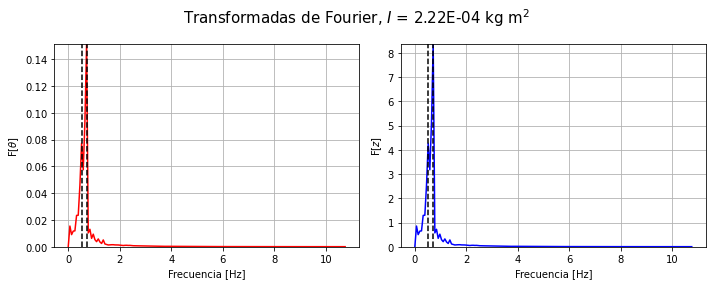

In [72]:
%matplotlib inline

xf = fft.rfftfreq(t.size,(t[-1]-t[0])/t.size) # Frecencias para la FFT
yf1 = np.abs(fft.rfft(theta,norm='forward')) # Amplitudes de frecuencia en theta
yf2 = np.abs(fft.rfft(z,norm='forward')) # Amplitud de frecuencia en z

# Figuras

fig2, ax2 = plt.subplots(1,2,sharex=True,figsize=(10, 4))

ax2[0].plot(xf,yf1,'r-')
ax2[0].set_ylabel('F[$\\theta$]')
ax2[0].set_xlabel('Frecuencia [Hz]')
ax2[0].grid()

ax2[1].plot(xf,yf2,'b-')
ax2[1].set_ylabel('F[$z$]')
ax2[1].set_xlabel('Frecuencia [Hz]')
ax2[1].grid()

I,dI = MoI(ra,rb)

plt.suptitle('Transformadas de Fourier, $I$ = {:.2E} kg m$^2$'.format(I),fontsize=15)
fig2.tight_layout()
fig2.subplots_adjust(hspace=0.2)

# Encontrar picos

modosTheta = max2Frec(xf,yf1,height=0.05) 
print(modosTheta)
ax2[0].axvline(x=modosTheta[0,0],color = 'k', linestyle = '--',linewidth = 1.5)
ax2[0].axvline(x=modosTheta[1,0],color = 'k', linestyle = '--',linewidth = 1.5)
#ax2[0].axvline(x=modosTheta[0],color = 'k', linestyle = '--',linewidth = 1.5)
ax2[0].set_ylim([0, np.max(yf1)])

modosZ = max2Frec(xf,yf2,height=0.1)
print(modosZ)
ax2[1].axvline(x=modosZ[0,0], color='k',linestyle = '--',linewidth = 1.5)
ax2[1].axvline(x=modosZ[1,0], color='k',linestyle = '--',linewidth = 1.5)
# ax1[0].axvline(x=modosZ[0],color = 'k', linestyle = '--',linewidth = 1.5)
ax2[1].set_ylim([0, np.max(yf2)])

name_fig = 'TransformadaTheta_'+sfx+'_'+str(i)+'.jpg'
plt.savefig(name_fig,dpi=200,bbox_inches='tight')

In [55]:
# Guarda los valores de momento de inercia y modos normales par un analisis posterior
file = 'valoresFinales'+str(i)+'.csv' #a,b,c,d,e,f,g,h
g = open(file,'a',newline='')
writer = csv.writer(g)
values = [I,dI]+list(modosTheta.reshape(-1))+list(modosZ.reshape(-1))
writer.writerow(values)
g.close()